In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor
using Logging

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config_large.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config_large2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 38:64 and 38:64 to the same range of 38:64
[ Info: Computing kinetic energie for improved bosonic sums.
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(38:64) = 0.3182, χLoc_ch(38:64) = 0.1222 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.2201987037827738 ?≈? 0.23524970649411947 ?=? 0.23524970649411947 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 2:100 and 2:100 to the same range of 2:100
[ Info: Computing kinetic energie for improved bosonic sums.
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(2:100) = 0.3466, χLoc_ch(2:100) = 0.1451 
└ sum χupup check (fit, tail sub, tail sub + fit, expe

# Lambda charge solutions investigation

In [3]:
# DMFT Energies
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:length(GImp)], ϵₖ, Vₖ, GImp, mP);

In [4]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [5]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [6]:
# non local quantities 
bubble2 = calc_bubble(νGrid, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid, sumHelper_f2, -mP2.U, mP2, sP2);

In [7]:
usable_ω = intersect(impQ_sp.usable_ω, impQ_ch.usable_ω)
χupup_DMFT_ω = real(impQ_sp.χ_ω .+ impQ_ch.χ_ω)[usable_ω] ./ 2

usable_ω2 = intersect(impQ_sp2.usable_ω, impQ_ch2.usable_ω)
χupup_DMFT_ω2 = real(impQ_sp2.χ_ω .+ impQ_ch2.χ_ω)[usable_ω2] ./ 2

χupup_ω_csum = LadderDGA.build_fνmax_fast(χupup_DMFT_ω, 50);
χupup_ω_csum2 = LadderDGA.build_fνmax_fast(χupup_DMFT_ω2, 50);

iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω] .* π ./ mP.β
iωn2 = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω2] .* π ./ mP.β
EKin = impQ_sp.tailCoeffs[3]
χupup_DMFT_ω_sub = LadderDGA.subtract_tail(χupup_DMFT_ω,EKin, iωn)
χupup_DMFT_ω_sub2 = LadderDGA.subtract_tail(χupup_DMFT_ω2,EKin, iωn2)

χupup_ω_sub_csum = LadderDGA.build_fνmax_fast(χupup_DMFT_ω_sub, 50);
χupup_ω_sub_csum2 = LadderDGA.build_fνmax_fast(χupup_DMFT_ω_sub2, 50);

println("TODO: tail for chi up do?")
χupdo_DMFT_ω2 = real(impQ_ch2.χ_ω .- impQ_sp2.χ_ω)[usable_ω2] ./ 2
χupdo_ω_csum2 = LadderDGA.build_fνmax_fast(χupdo_DMFT_ω2, 50);
χupdo_ω_sub_csum2 = χupdo_ω_csum2;

TODO: tail for chi up do?


In [8]:
exps_l = [0:i for i in 1:6]

res = zeros(length(exps_l),  50 - 1,4)  # no nu fit, nu fit, no nu fit + sub, nu fit + sub
for (j,exps) in enumerate(exps_l)
for i in 1:50 - maximum(exps)
    ind = exps .+ i
    sh = LadderDGA.Richardson(ind,exps,method=:bender)
    sh2 = LadderDGA.Richardson(exps .+ 1,exps,method=:bender)
    res[j,i,1] = real.(sum(χupdo_ω_csum2[ind])) ./ mP2.β
    res[j,i,2] = LadderDGA.esum_c(real.(χupdo_ω_sub_csum2)[ind] ./ mP2.β, sh2)
    res[j,i,3] = LadderDGA.esum_c(real.(χupup_ω_csum2)[ind]./ mP2.β, sh2) 
    res[j,i,4] = LadderDGA.esum_c(real.(χupup_ω_sub_csum2)[ind]./ mP2.β, sh2)  .- EKin*mP.β/12
end
end

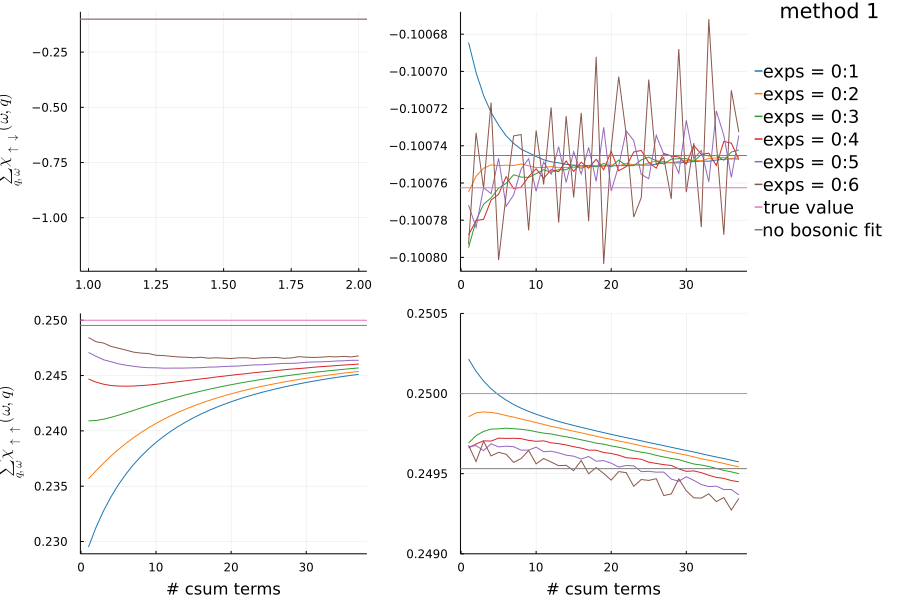

In [28]:
using Plots
using LaTeXStrings
#l = @layout([[A B] E{.15w}])
l = @layout([[A B; C D] E{.15w}])
# method $method
colors = palette(:tab10)
p = Array{Plots.Plot,1}(undef, 5)
v1 = χupdo_ω_sub_csum2[end] ./ mP.β 
v2 = χupup_ω_sub_csum2[end] ./ mP.β .- EKin*mP.β/12
ind = 8:(size(res,2)-5)

p[1] = plot(real([χupdo_ω_csum2[end]]), c=colors[1], ylabel=L"$\sum_{q,\omega}  \chi_{\uparrow\downarrow}(\omega, q)$", legend=false)
p[2] = plot(res[1,ind,2], c=colors[1])
p[3] = plot(res[1,ind,3], c=colors[1], xlabel="# csum terms", ylabel=L"$\sum_{q,\omega}  \chi_{\uparrow\uparrow}(\omega, q)$", legend=false)
p[4] = plot(res[1,ind,4], c=colors[1], xlabel="# csum terms", legend=false, ylims=(0.249,0.2505))  
for method in 2:4
    for i in 2:size(res,1)
        plot!(p[method], res[i,ind,method], c=colors[i], label="$(i+1) exps", legend=false)
    end
end
hline!(p[1], [(E_pot_ED/mP.U) - mP.U * (mP.n/2)^2], c=colors[size(res,1)+1], label="true value")
hline!(p[2], [(E_pot_ED/mP.U) - mP.U * (mP.n/2)^2], c=colors[size(res,1)+1], label="true value")
hline!(p[3], [0.25], c=colors[size(res,1)+1], label="true value")
hline!(p[4], [0.25], c=colors[size(res,1)+1], label="true value")
hline!(p[1], [v1], c=colors[(size(res,1)+2)], label="pure sub")  
hline!(p[2], [v1], c=colors[(size(res,1)+2)], label="pure sub")
hline!(p[3], [v2], c=colors[(size(res,1)+2)], label="pure sub")  
hline!(p[4], [v2], c=colors[(size(res,1)+2)], label="pure sub")

p[5] = plot([0 for y in 1:1, i in 1:(size(res,1)+2)], title=["method 1" "mthod 2" "method 3" "method 4" ""], palette = :tab10, legendfontsize=12 , foreground_color_legend = nothing, showaxis = false, ticks=false, grid = false, label = hcat(["exps = $(exps_l[i])" for y in 1:1, i in 1:size(res,1)],["true value"  "no bosonic fit"])) #
#mval, mind = findmin(abs.(res[3,:,4] .- 0.25))
#println("best candidate: tail subtraction + 0:4 exp fit at index $mind range. result = $(round(res[3,mind,4],digits=7)).\nPure tail subtraction for bosonic frequencies gives $(round(v,digits=7))")
plot(p..., layout = l, size = (900, 600))

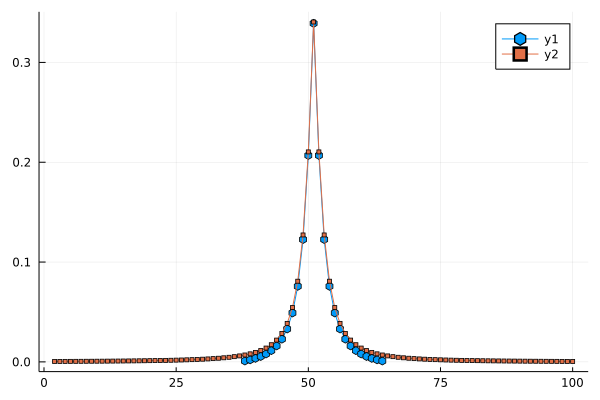

In [12]:

kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β



sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
χsp_ω = kintegrate(kGrid, nlQ_sp.χ, dim=2)[:,1]
χsp_sum = real(sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
χsp_ω_2 = kintegrate(kGrid, nlQ_sp2.χ, dim=2)[:,1]
χsp_sum_2 = real(sum_freq(χsp_ω_2[nlQ_sp2.usable_ω], [1], sh_2, mP2.β)[1])
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)

plot(nlQ_ch.usable_ω, real(χch_ω[nlQ_ch.usable_ω]),markershape = :hexagon,markersize = 4)
plot!(nlQ_ch2.usable_ω, real(χch_ω_2[nlQ_ch2.usable_ω]),markershape = :square,markersize = 2)

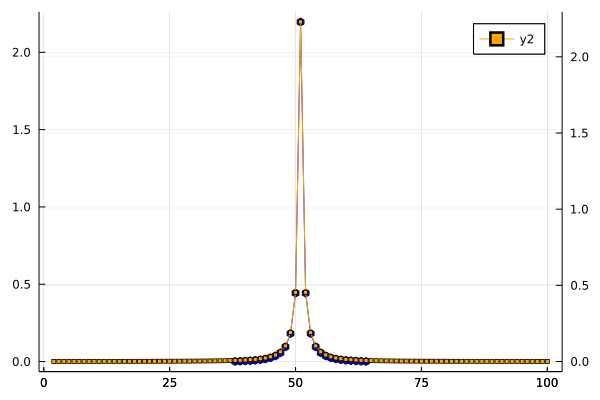

In [13]:
plot(nlQ_sp.usable_ω, real(χsp_ω[nlQ_sp.usable_ω]),markershape = :hexagon,markersize = 4,c=:blue)
plot!(twinx(),[i for i in nlQ_sp2.usable_ω if i != 510], real(χsp_ω_2[[i for i in nlQ_sp2.usable_ω if i != 510]]), c=:orange,markershape = :square,markersize = 2)

In [14]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(38:64,38:64) = 38:64 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 38:64, length: 27
│ ch: 38:64, length: 27
│ usable: 38:64, length: 27
└ χch sum = 0.13617219681705406, rhs = 0.36382780318294594
┌ Info: found 
│   χ_min = -0.09022526652199882
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.09022526652199882, 1.8045053304399763]"
┌ Info: Method 2 root:
└   r2 = Float64[]
┌ Info: Found λsp 
└   λsp_old = -0.031002515238863833
[ Info: new lambda correction: λsp=0.37079198316799533 and λch=-3.0477792918873813e12


(-0.031002515238863833, [0.37079198316799533, -3.0477792918873813e12], [-0.09022526652199882, 1.8045053304399763], [-Inf, Inf])

In [15]:
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(2:100,2:100) = 2:100 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 2:100, length: 99
│ ch: 2:100, length: 99
│ usable: 2:100, length: 99
└ χch sum = 0.1477048552279611, rhs = 0.35229514477203894
┌ Info: found 
│   χ_min = -0.08909247230634672
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.08909247230634672, 1.7818494461269343]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.021299181478571457
┌ Info: Found λsp 
└   λsp_old = 0.02129918147837787
[ Info: new lambda correction: λsp=0.32858571988844454 and λch=3.30449148326628e12


(0.02129918147837787, [0.32858571988844454, 3.30449148326628e12], [-0.08909247230634672, 1.7818494461269343], [-Inf, Inf])

In [16]:
χsp = 1 ./ ( (1 ./ nlQ_sp.χ) .- nlQ_sp.λ);
χsp2 = 1 ./ ( (1 ./ nlQ_sp2.χ) .- nlQ_sp2.λ);
χr = real.(χsp[nlQ_sp.usable_ω, :]);
χr2 = real.(χsp2[nlQ_sp2.usable_ω, :]);

In [17]:
sh = get_sum_helper(usable_ω, sP, :b)
sh2 = get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)


iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[nlQ_sp2.usable_ω] .* π ./ mP.β
EKin = impQ_sp.tailCoeffs[3]
f(x) = sum_freq(kintegrate(qG, χ_λ(χr, x), dim=2)[:,1], [1], sh, mP.β)[1] - 0.36382780318294594
f2(x) = sum_freq(LadderDGA.subtract_tail(kintegrate(qG, χ_λ(χr2, x), dim=2)[:,1],EKin, iωn), [1], LadderDGA.Naive(), mP.β, corr=-EKin*mP.β^2/12)[1] - 0.35229514477203894
f3(x) = sum_freq(kintegrate(qG, χ_λ(χr2, x), dim=2)[:,1], [1], sh, mP.β)[1] - 0.35229514477203894 

f3 (generic function with 1 method)

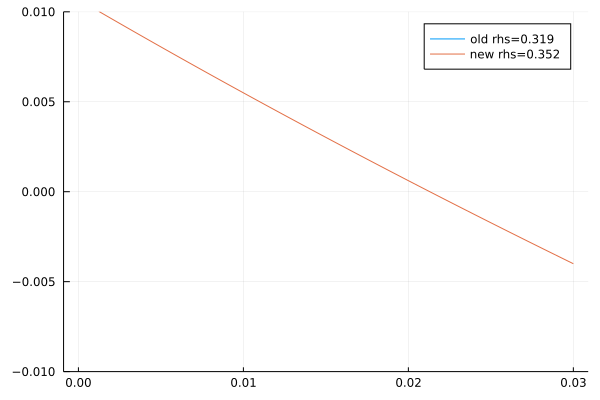

In [18]:
xarr = 0.0:0.0001:0.03
#xarr =  0.028:0.0001:0.032

plot(xarr,f.(xarr), label="old rhs=0.319", ylim=(-0.01,0.01))
plot!(xarr,f2.(xarr), label="new rhs=0.352")


In [19]:
sh = get_sum_helper(2*sP.n_iν, sP2, :f)

#test = sum_freq(impQ_sp.χ .+ impQ_ch.χ,[2,3],sh,mP2.β)[:,1,1]
test1 = sum_freq(impQ_sp.χ,[2,3],sh,mP2.β)[:,1,1]
test2 = sum_freq(impQ_ch.χ,[2,3],sh,mP2.β)[:,1,1]
r1 = LadderDGA.find_usable_interval(real.(test1),reduce_range_prct=0.1)[:,1,1]
r2 = LadderDGA.find_usable_interval(real.(test2),reduce_range_prct=0.1)[:,1,1]
sh2_1 = get_sum_helper(r1, sP2, :b)
sh2_2 = get_sum_helper(r2, sP2, :b)
sum_freq(test1[r1], [1], sh2_1,mP2.β) .+ sum_freq(test2[r2], [1], sh2_2,mP2.β)

0.4911311689274391 - 5.267438026718742e-10im

In [20]:
sh = get_sum_helper(2*sP.n_iν, sP2, :f)

test = sum_freq(impQ_sp2.χ .+ impQ_ch2.χ,[2,3],sh,mP2.β)[:,1,1]
r1 = LadderDGA.find_usable_interval(real.(test),reduce_range_prct=-0.1)[:,1,1]
sh2 = get_sum_helper(r1, sP2, :b)
sum_freq(test[r1], [1], sh2_1,mP2.β)

LoadError: BoundsError: attempt to access 101-element Vector{ComplexF64} at index [[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5  …  97, 98, 99, 100, 101, 102, 103, 104, 105, 106]]

In [21]:

r = intersect(impQ_sp2.usable_ω, impQ_ch2.usable_ω)
sh2 = get_sum_helper(r, sP2, :b)
sum_freq(impQ_sp2.χ_ω[r] .+ impQ_ch2.χ_ω[r], [1], sh2,mP2.β )

0.49171433465625647 - 5.267438049096067e-10im

In [22]:
χr = real.(χsp[nlQ_sp.usable_ω, :]);
χr2 = real.(χsp2[nlQ_sp2.usable_ω, :]);
rhs = 0.36415246809110613
sh2 = get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr2, λint), dim=2)[:,1], [1], sh2, mP2.β)[1] - rhs
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr2, λint) .^ 2, dim=2)[:,1], [1], sh2, mP2.β)[1]
χ_min = -0.08920733408245121
-0.08920733408245121

-0.08920733408245121

In [23]:
using Roots

get_sum_helper = LadderDGA.get_sum_helper
kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β


sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
rhs1 = mP.n * (1 - mP.n/2) - χch_sum
rhs2 = real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
sh = get_sum_helper(usable_ω, sP, :b)
χupup_sum = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch.χ[usable_ω,:] .+ nlQ_sp.χ[usable_ω,:]), dim=2)[:,1], [1], sh, mP.β)[1]


sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
rhs1_2 = mP.n * (1 - mP.n/2) - χch_sum_2
rhs2_2 = real(impQ_ch2.χ_loc + impQ_sp2.χ_loc - χch_sum_2)
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)
sh_2 = get_sum_helper(usable_ω_2, sP2, :b)
χupup_sum_2 = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch2.χ[usable_ω_2,:] .+ nlQ_sp2.χ[usable_ω_2,:]), dim=2)[:,1], [1], sh_2, mP2.β)[1]

println("usable range: $usable_ω vs $usable_ω_2\nχupup_nc=$χupup_sum\nχupup_rc=$χupup_sum_2")

χ_in = nlQ_sp.χ
usable_ω_i = nlQ_sp.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs2
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r2 = find_zeros(f, 0.02, 20.0, verbose=true)

χ_in = nlQ_sp2.χ
usable_ω_i = nlQ_sp2.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP2, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs1
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r22 = find_zeros(f, 0.02, 20.0, verbose=true)

println("lambda $r2 vs $r22")

LoadError: cannot assign a value to variable LadderDGA.get_sum_helper from module Main

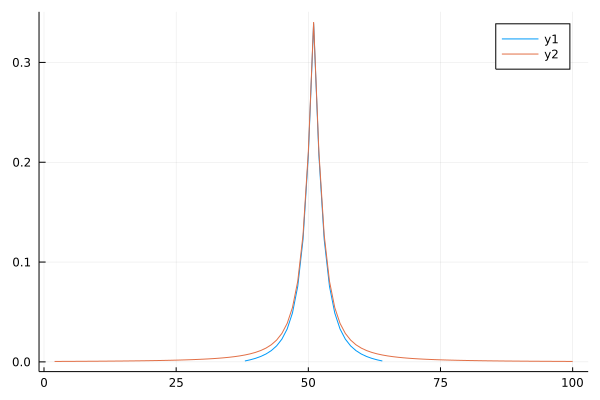

In [24]:
plot(usable_ω, real(χch_ω[usable_ω]))
plot!(usable_ω_2, real(χch_ω_2[usable_ω_2]))